In [19]:
#!pip install --upgrade google-api-python-client
import nltk #para procesamiento de lenguaje natural
nltk.download('popular') # Descarga recursos populares de NLTK
nltk.download('vader_lexicon')#lexicón VADER para análisis de sentimiento
nltk.download('punkt_tab')  #Datos adicionales para tokenización 
from googleapiclient.discovery import build #API de Google para interactuar con servicios de Google, como YouTube o Sheets
from nltk.sentiment.vader import SentimentIntensityAnalyzer#Analizador de sentimientos VADER de NLTK
import re #para trabajar con expresiones regulares
from nltk.tokenize import word_tokenize #tokenizador de palabras de NLTK
from nltk.corpus import stopwords # Importa la lista de palabras vacías (stopwords)
# Importa el lematizador de palabras para reducir palabras a su forma base
from nltk.stem import WordNetLemmatizer
import pandas as pd
import matplotlib.pyplot as plt


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\Desarrollo05\AppData\Roaming\nltk_data..
[nltk_data]    |     .
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\Desarrollo05\AppData\Roaming\nltk_data..
[nltk_data]    |     .
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\Desarrollo05\AppData\Roaming\nltk_data..
[nltk_data]    |     .
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\Desarrollo05\AppData\Roaming\nltk_data..
[nltk_data]    |     .
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\Desarrollo05\AppData\Roaming\nltk_data..
[nltk_

In [20]:
# Configuración de YouTube API
youtube = build("youtube", "v3", developerKey="Escribe_tu_API")

In [25]:
comments = [] #Almacenar los comentarios de YouTube
page_token = None # Inicializa el token de página para paginación

# Bucle para obtener todos los comentarios de un video, página por página
while True:
    # Crea una solicitud para obtener los comentarios del video especificado
    request = youtube.commentThreads().list(
        part="snippet",         # Define qué parte de los datos del comentario se va a recuperar
        videoId="fUEjCXpOjPY",  # Especifica el ID del video de YouTube
        maxResults=100,         # Define el número máximo de comentarios por solicitud (máximo permitido es 100)
        pageToken=page_token    # Usa el token para avanzar a la siguiente página de comentarios
    )
    
    # Ejecuta la solicitud y obtiene la respuesta
    response = request.execute()
    
    # Extrae el texto de los comentarios principales y los agrega a la lista de comentarios
    comments.extend([
        item['snippet']['topLevelComment']['snippet']['textOriginal'] 
        for item in response['items']
    ])
    
    # Obtiene el token de la siguiente página, si existe
    page_token = response.get('nextPageToken')
    
    # Si no hay más páginas (es decir, no hay más token), finaliza el bucle
    if not page_token:
        break


In [21]:
# Limpia el texto eliminando todos los caracteres no alfabéticos y los espacios extra
def clean_text(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

# Convierte todo el texto a minúsculas para unificar el formato
def to_lower(text):
    return text.lower()

# Divide el texto en palabras (tokens) utilizando el tokenizador de NLTK
def tokenize(text):
    return word_tokenize(text)

# Elimina las palabras vacías (stopwords) del texto, como "the", "is", "and", etc.
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))  # Carga la lista de palabras vacías en inglés
    return [word for word in text if word not in stop_words]

# Reduce las palabras a su forma base utilizando un lematizador
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()  # Inicializa el lematizador de NLTK
    return [lemmatizer.lemmatize(word) for word in text]

# Aplica todas las funciones de limpieza de texto en secuencia para limpiar completamente el texto
def complete_clean(text):
    text = clean_text(text)           # Elimina caracteres no alfabéticos
    text = to_lower(text)             # Convierte a minúsculas
    text = tokenize(text)             # Tokeniza el texto
    text = remove_stopwords(text)     # Elimina palabras vacías
    text = lemmatize(text)            # Lematiza las palabras
    return text


In [22]:
# Limpieza de comentarios
# Aplica la función de limpieza completa a cada comentario en la lista 'comments'
clean_comments = [complete_clean(comment) for comment in comments]

# Une los tokens de cada comentario limpio en una sola cadena de texto
# Si el resultado de la limpieza es una lista (lo esperado), se une con espacios.
# Si no es una lista (caso excepcional), se mantiene el comentario como está.
clean_comments = [' '.join(comment) if isinstance(comment, list) else comment for comment in clean_comments]


In [23]:
# Análisis de sentimiento
# Inicializa el analizador de sentimiento VADER
sia = SentimentIntensityAnalyzer()

# Aplica el análisis de sentimiento a cada comentario limpio
# Para cada comentario, genera un diccionario con puntajes de positividad, negatividad, neutralidad y el puntaje compuesto
sentiments = [sia.polarity_scores(comment) for comment in clean_comments]

In [24]:
df = pd.DataFrame(sentiments)
print(df)

        neg    neu    pos  compound
0     0.178  0.695  0.127   -0.6908
1     0.000  0.000  0.000    0.0000
2     0.000  0.000  1.000    0.4404
3     0.586  0.414  0.000   -0.8591
4     0.143  0.690  0.167    0.2500
...     ...    ...    ...       ...
2529  0.000  0.220  0.780    0.7964
2530  0.000  0.000  1.000    0.4215
2531  0.000  0.000  1.000    0.4215
2532  0.000  1.000  0.000    0.0000
2533  0.178  0.695  0.127   -0.6908

[2534 rows x 4 columns]


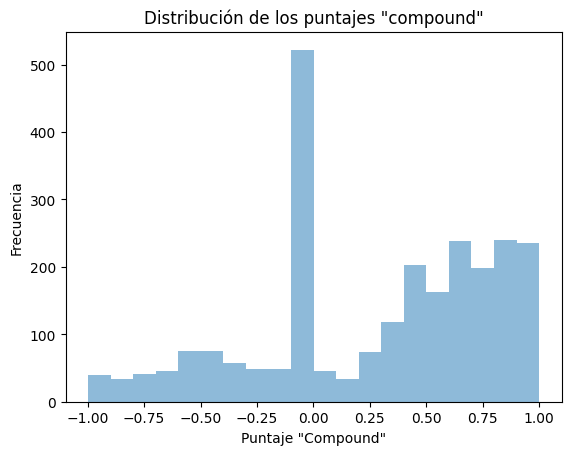

In [17]:
# Distribución de los puntajes "compound"
compound_scores = [item['compound'] for item in sentiments]
plt.hist(compound_scores, bins=20, alpha=0.5)
plt.title('Distribución de los puntajes "compound"')
plt.xlabel('Puntaje "Compound"')
plt.ylabel('Frecuencia')
plt.show()